# Predict GPU performance from other GPUs
### Use model trained on training data set from 5 GPUs, test on (all) data from remaining GPU

In [1]:
import os
import sys
import tensorflow as tf
import numpy as np
from sklearn.externals import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

In [2]:
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library

In [3]:
from prediction_model import dataprep

In [4]:
predict = 'V100'
data_model = 'only_%s' %predict

prediction_model = 'no_%s' %predict

In [5]:
# Set paths
PREDICTION_PATH = os.path.join(ROOT_DIR, 'prediction_model/models/%s/saved_model' %prediction_model)
SCALER_PATH = os.path.join(ROOT_DIR, 'prediction_model/models/%s/scaler_Conv.save' %prediction_model)
DATA_PATH = os.path.join(ROOT_DIR, 'prediction_model/data/Data_convolution_%s.pkl' %data_model)

In [6]:
scaler = joblib.load(SCALER_PATH)
df = pd.read_pickle(DATA_PATH)
tfmodel_file = PREDICTION_PATH

In [7]:
df.describe()

,batchsize,channels_in,channels_out,gpu,kernelsize,matsize,padding,precision,strides,timeUsed_max,...,opt_SGD,act_None,act_relu,act_sigmoid,act_tanh,peak_performance,IO,bandwidth,cores,clock
count,24905.000000,24905.000000,24905.000000,24905.0,24905.000000,24905.000000,24905.000000,24905.0,24905.000000,24905.000000,...,24905.000000,24905.000000,24905.000000,24905.000000,24905.000000,24905.0,24905.0,24905.0,24905.0,24905.0
mean,16.359245,66.010801,67.450472,0.0,3.993415,254.995904,0.504798,32.0,2.487934,4.549551,...,0.086649,0.255852,0.251917,0.249629,0.242602,14900.0,300.0,900.0,5120.0,1455.0
std,9.228296,316.859258,328.612518,0.0,2.010322,147.970062,0.499987,0.0,1.112067,7.346485,...,0.281326,0.436348,0.434123,0.432807,0.428665,0.0,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,0.0,1.000000,1.000000,0.000000,32.0,1.000000,0.148177,...,0.000000,0.000000,0.000000,0.000000,0.000000,14900.0,300.0,900.0,5120.0,1455.0
25%,8.000000,10.000000,10.000000,0.0,2.000000,127.000000,0.000000,32.0,2.000000,0.881681,...,0.000000,0.000000,0.000000,0.000000,0.000000,14900.0,300.0,900.0,5120.0,1455.0
50%,16.000000,19.000000,19.000000,0.0,4.000000,253.000000,1.000000,32.0,2.000000,1.907144,...,0.000000,0.000000,0.000000,0.000000,0.000000,14900.0,300.0,900.0,5120.0,1455.0
75%,24.000000,39.000000,39.000000,0.0,6.000000,384.000000,1.000000,32.0,3.000000,4.985938,...,0.000000,1.000000,1.000000,0.000000,0.000000,14900.0,300.0,900.0,5120.0,1455.0
max,32.000000,9438.000000,9658.000000,0.0,7.000000,512.000000,1.000000,32.0,4.000000,103.305259,...,1.000000,1.000000,1.000000,1.000000,1.000000,14900.0,300.0,900.0,5120.0,1455.0


In [8]:
data_cols_conv = ['batchsize','elements_matrix','elements_kernel','channels_in','channels_out','padding','strides','use_bias', 
                      'opt_SGD','opt_Adadelta','opt_Adagrad','opt_Momentum','opt_Adam','opt_RMSProp',
                      'act_relu','act_tanh','act_sigmoid',
                      'bandwidth','cores','clock']
split=[0,0,1]

In [9]:
data, time, train, test, validation = dataprep.data_preprocess_keep(df,data_cols_conv,split,scaler)

Size of train dataset: 0 
Size of test dataset: 0 
Size of validation dataset: 24905


/Users/djustus/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


INFO:tensorflow:Restoring parameters from /Users/djustus/workspace/newcastle/ml-performance-prediction/prediction_model/models/no_V100/saved_model/variables/variables


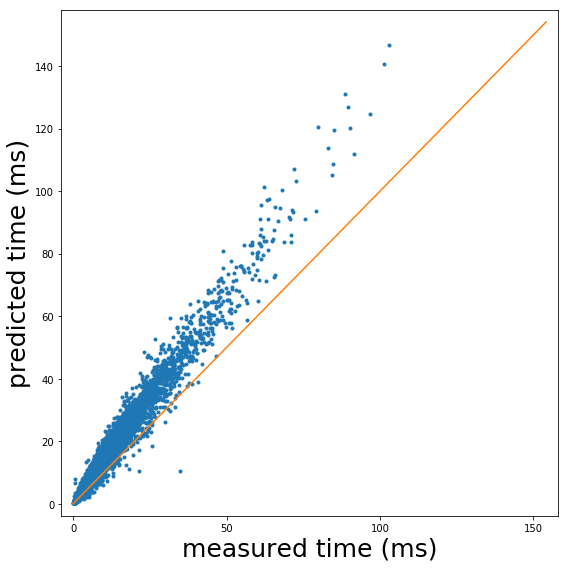

In [10]:
with tf.Session() as sess:
    tf.saved_model.loader.load(sess, ["serve"], tfmodel_file)
    graph = tf.get_default_graph()


    run = sess.run(
            'model_prediction:0',
            feed_dict={'model_input:0': data['Validation'], 
                       'model_targets:0': time['Validation'],
                       'model_istraining:0': False})
RMS_validation_error=np.sqrt(np.mean((time['Validation']-run)**2))
perc_error = np.mean(np.abs(time['Validation']-run)/time['Validation'])*100

fig,ax = plt.subplots(1,1,figsize=[8,8])
ax.plot(time['Validation'],run,'.')


ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.xaxis.set_minor_formatter(plt.NullFormatter())
ax.yaxis.set_minor_formatter(plt.NullFormatter())

matplotlib.rc('xtick', labelsize=25) 
matplotlib.rc('ytick', labelsize=25) 

plt.xlabel('measured time (ms)',fontsize=25)
plt.ylabel('predicted time (ms)',fontsize=25)


axlim = max(plt.xlim()[1],plt.ylim()[1])


#plt.axis('equal')
ax.set_xlim(-axlim*.025,axlim*1.025)
ax.set_ylim(-axlim*.025,axlim*1.025)

plt.tight_layout()
ax.ticklabel_format(useOffset=False)
ax.plot([0,axlim],[0,axlim],2)

#plt.savefig('figures/prediction_%s_from_other.png' %predict, dpi=300)

plt.show()

In [11]:
RMS_validation_error

3.6470957

In [12]:
perc_error

39.57671523094177